### Sample code for Comparing NILM algorithms

In [39]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

### Dividing data into train and test set

In [40]:
path_h5 = './data_ecco/ecco.h5'

train = DataSet(path_h5)
test = DataSet(path_h5)

Let us use building 1 for demo purposes

In [41]:
building = 1

In [42]:
# The dates are interpreted by Pandas, prefer using ISO dates (yyyy-mm-dd)
train.set_window(end="2012-07-01")
test.set_window(start="2012-07-01", end="2012-07-15")

train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

In [43]:
train_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='ECO', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='ECO', site_meter, appliances=[])
  ElecMeter(instance=3, building=1, dataset='ECO', site_meter, appliances=[])
  ElecMeter(instance=4, building=1, dataset='ECO', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=5, building=1, dataset='ECO', appliances=[Appliance(type='hair dryer', instance=1)])
  ElecMeter(instance=6, building=1, dataset='ECO', appliances=[Appliance(type='coffee maker', instance=1)])
  ElecMeter(instance=7, building=1, dataset='ECO', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=8, building=1, dataset='ECO', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=9, building=1, dataset='ECO', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=10, building=1, dataset='ECO', appliances=[Appliance(type='freezer', instance=1)])
)

### Selecting top-5 appliances

In [44]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

7/7 ElecMeter(instance=10, building=1, dataset='ECO', appliances=[Appliance(type='freezer', instance=1)])ce=1)])

In [45]:
# top_1_test_elec = test_elec.submeters().select_top_k(k=1)

### Training and disaggregation

In [46]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(physical_quantity='power', ac_type='active', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i] = {}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = next(meter.load(physical_quantity='power', ac_type='active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [47]:
# Since the methods use randomized initialization, let's fix a seed here
# to make this notebook reproducible
np.random.seed(59)

In [48]:
# for chunk in test_elec.mains().load(sample_period=120):
#     chunk_drop_na = chunk.dropna()
#     print(chunk_drop_na.index)
#     break

In [49]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM': FHMM()}
predictions = {}
sample_period = 240

for clf_name, clf in classifiers.items():
    print("*" * 20)
    print(clf_name)
    print("*" * 20)
    clf.train(top_5_train_elec, sample_period=sample_period)
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

********************
CO
********************
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='ECO', appliances=[Appliance(type='washing machine', instance=1)])'


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=5, building=1, dataset='ECO', appliances=[Appliance(type='hair dryer', instance=1)])'


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=4, building=1, dataset='ECO', appliances=[Appliance(type='fridge', instance=1)])'


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=10, building=1, dataset='ECO', appliances=[Appliance(type='freezer', instance=1)])'


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=9, building=1, dataset='ECO', appliances=[Appliance(type='computer', instance=1)])'
Done training!
2012-06-30 20:00:00-04:00 2012-07-14 20:00:00-04:00
Loading data for meter ElecMeterID(instance=1, building=1, dataset='ECO')     

/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Loading data for meter ElecMeterID(instance=3, building=1, dataset='ECO')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='ECO', appliances=[Appliance(type='washing machine', instance=1)])'
(5010, 1)
(5010,)
(5010,)
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='ECO', appliances=[Appliance(type='hair dryer', instance=1)])'
(5010, 1)
(5010,)
(5010,)
Estimating power demand for 'ElecMeter(instance=4, building=1, dataset='ECO', appliances=[Appliance(type='fridge', instance=1)])'
(5010, 1)
(5010,)
(5010,)
Estimating power demand for 'ElecMeter(instance=10, building=1, dataset='ECO', appliances=[Appliance(type='freezer', instance=1)])'
(5010, 1)
(5010,)
(5010,)
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='ECO', appliances=[Appliance(type='computer', instance=1)])'
(5010, 1)
(5010,)
(5010,)
********************
FHMM
********************


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=8, building=1, dataset='ECO', appliances=[Appliance(type='washing machine', instance=1)])' with 3 states


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=5, building=1, dataset='ECO', appliances=[Appliance(type='hair dryer', instance=1)])' with 3 states


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=4, building=1, dataset='ECO', appliances=[Appliance(type='fridge', instance=1)])' with 3 states


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=10, building=1, dataset='ECO', appliances=[Appliance(type='freezer', instance=1)])' with 3 states


/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/e.taychinov/nilmtk/venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Training model for submeter 'ElecMeter(instance=9, building=1, dataset='ECO', appliances=[Appliance(type='computer', instance=1)])' with 3 states
2012-06-30 20:00:00-04:00 2012-07-14 20:00:00-04:00
Loading data for meter ElecMeterID(instance=3, building=1, dataset='ECO')     
Done loading data all meters for this chunk.


In [50]:
appliance_labels = [m.label() for m in gt.columns.values]
gt.columns = appliance_labels
predictions['CO'].columns = appliance_labels
predictions['FHMM'].columns = appliance_labels

Taking a look at the ground truth of top 5 appliance power consumption

In [51]:
gt.head()

,Washing machine,Hair dryer,Fridge,Freezer,Computer
2012-07-01 02:00:00+02:00,0.065945,0.073020,1.323468,1.599442,9.680392
2012-07-01 02:04:00+02:00,0.131890,0.073020,1.341850,5.066944,9.698332
2012-07-01 02:08:00+02:00,0.103628,0.073020,1.314277,34.076313,9.770094
2012-07-01 02:12:00+02:00,0.094207,0.082147,1.305087,33.537062,9.689362
2012-07-01 02:16:00+02:00,0.094207,0.045637,1.268324,32.988825,9.743184


In [52]:
predictions['CO'].head()

,Washing machine,Hair dryer,Fridge,Freezer,Computer
2012-07-01 02:00:00+02:00,0.0,0.0,0.0,32.0,19.0
2012-07-01 02:04:00+02:00,0.0,0.0,22.0,32.0,0.0
2012-07-01 02:08:00+02:00,0.0,0.0,50.0,17.0,19.0
2012-07-01 02:12:00+02:00,0.0,0.0,50.0,32.0,19.0
2012-07-01 02:16:00+02:00,0.0,58.0,0.0,32.0,0.0


In [53]:
predictions['FHMM'].head()

,Washing machine,Hair dryer,Fridge,Freezer,Computer
2012-07-01 02:00:00+02:00,1.0,748.0,26.0,11.0,48.0
2012-07-01 02:04:00+02:00,1.0,6.0,2.0,2.0,48.0
2012-07-01 02:08:00+02:00,1.0,0.0,26.0,11.0,48.0
2012-07-01 02:12:00+02:00,1.0,0.0,50.0,2.0,48.0
2012-07-01 02:16:00+02:00,1.0,0.0,26.0,11.0,48.0


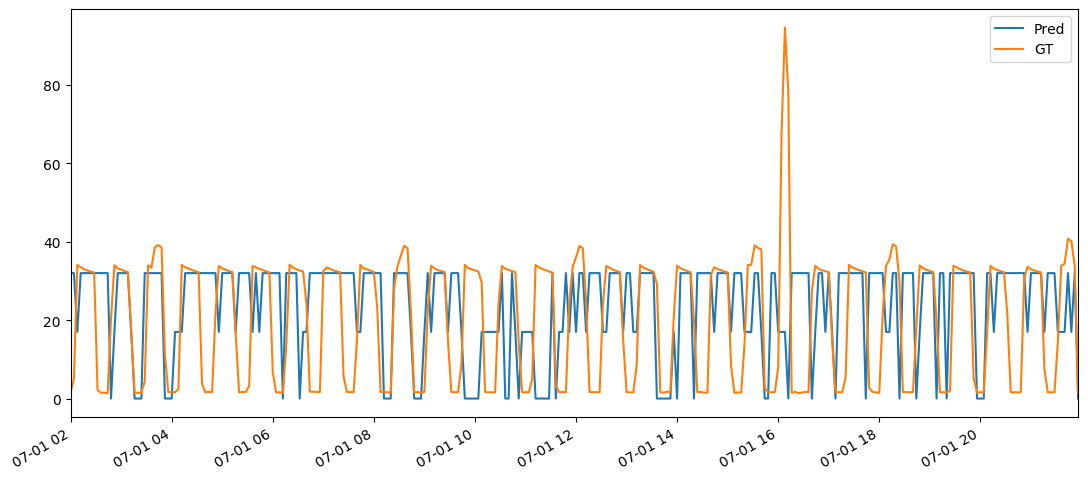

In [64]:
predictions['CO']['Freezer'].head(300).plot(label="Pred")
gt['Freezer'].head(300).plot(label="GT")
plt.legend()

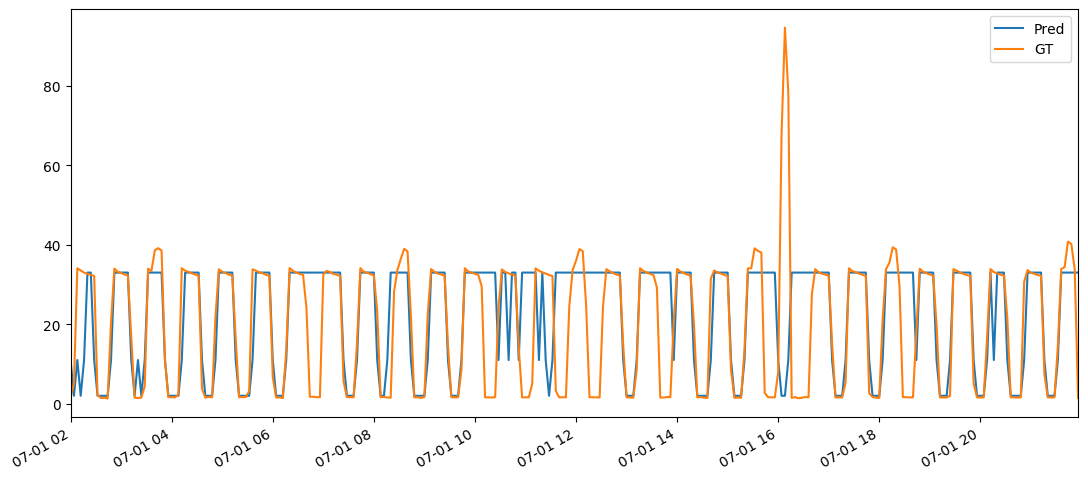

In [65]:
predictions['FHMM']['Freezer'].head(300).plot(label="Pred")
gt['Freezer'].head(300).plot(label="GT")
plt.legend()

In [56]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name], pretty=True)

rmse = pd.DataFrame(rmse)

In [57]:
rmse

,CO,FHMM
Washing machine,30.750449,34.804799
Hair dryer,40.797150,40.871742
Fridge,32.009751,15.716338
Freezer,18.419335,12.730367
Computer,21.378592,39.959303
